# CNN Cancer Detection

The goal of this notebook is to use Convolutional Neural Network (CNN) to process images of healthy cells and cancer cells, and be able to classify those images. Cancer impacts millions of people every year. Being able to quickly identify cancer in a person can help doctors provide treatment and save lives.

The link to the Github repo is [here](https://github.com/poreeves/CNN-Cancer-Detection)

We will be using Tensorflow and Keras libraries to build our CNN model.

In [28]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras


from skimage import io
import cv2 as cv

from sklearn.model_selection import GridSearchCV

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,  MaxPool2D, Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam


import numpy as np
from PIL import Image

In [2]:
pip install opendatasets

In order to import the dataset you need to have a Kaggle account and you use your API key. [Instructions](https://github.com/Kaggle/kaggle-api#api-credentials)

In [3]:
import opendatasets as od

It may take a few minutes to import the data folders.

In [4]:
od.download(
    "https://www.kaggle.com/competitions/histopathologic-cancer-detection/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: philreeves
Your Kaggle Key: ··········


100%|██████████| 6.31G/6.31G [00:37<00:00, 182MB/s]



Extracting archive ./histopathologic-cancer-detection/histopathologic-cancer-detection.zip to ./histopathologic-cancer-detection


We will be exporting a csv file and uploading to to Kaggle.

In [5]:
from google.colab import files


# EDA

Let's take a look at the data. First let's see what folders are in the data imported.

In [6]:
print(os.listdir('./histopathologic-cancer-detection'))
train_path = './histopathologic-cancer-detection/train'
test_path = './histopathologic-cancer-detection/test'
df_labels = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')


['sample_submission.csv', 'train', 'test', 'train_labels.csv']


Our data consists of a training folder with images, a test folder with images, and the training labels. Let's take a look at the training labels first.

In [7]:
df_labels['id'] = df_labels['id'].astype('str') + '.tif'
df_labels['label'] = df_labels['label'].astype('str')
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


We will need to update the id strings in the labels  to include the file type. Also, our model needs the classification (label) to be a string.

In [8]:
count = df_labels['label'].value_counts().values
total = len(df_labels['label'])
perct = df_labels['label'].value_counts().values / len(df_labels['label'])
print(count)
print(total)
print(perct)

[130908  89117]
220025
[0.59496875 0.40503125]


It looks like there are 130908 health images, 89117 cancer images, and a total number of images in the training set is 220025. That is about a 60-40 split. Let's set up a graph to get a visual idea of the training data.

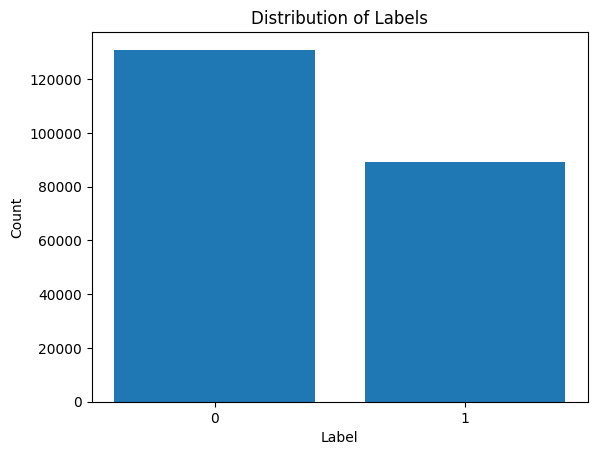

In [9]:
plt.bar(df_labels['label'].value_counts().index, df_labels['label'].value_counts().values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


Next, let's take a look at the images. Let's confirm their shape and then plot some.

In [10]:
df_labels['id'][0]

'f38a6374c348f90b587e046aac6079959adf3835.tif'

In [11]:
for i in range(20):
  img = np.asarray(Image.open(train_path + '/' + df_labels['id'][i]))
  print(img.shape)


(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


Let's take a look at the first image in the data set.

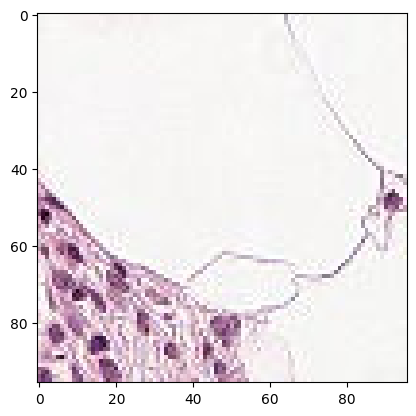

In [12]:
img = np.asarray(Image.open(train_path + '/' + df_labels['id'][0]))
imgplot = plt.imshow(img)


Let's plot a few more with their labels.

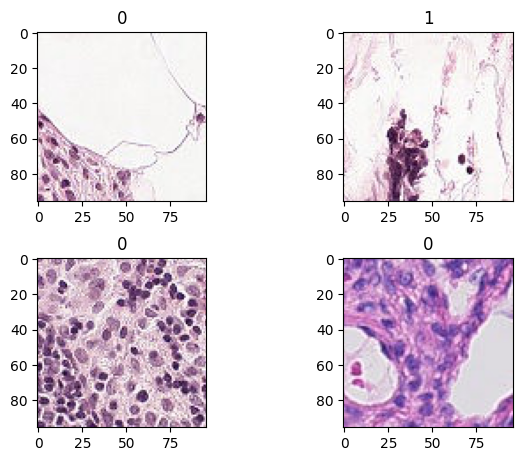

In [13]:
fig, ax = plt.subplots(2,2)
fig.tight_layout(pad=2.0)
ax[0,0].imshow(np.asarray(Image.open(train_path + '/' + df_labels['id'][0])))
ax[0,0].set_title(df_labels['label'][0])
ax[0,1].imshow(np.asarray(Image.open(train_path + '/' + df_labels['id'][1])))
ax[0,1].set_title(df_labels['label'][1])
ax[1,0].imshow(np.asarray(Image.open(train_path + '/' + df_labels['id'][2])))
ax[1,0].set_title(df_labels['label'][2])
ax[1,1].imshow(np.asarray(Image.open(train_path + '/' + df_labels['id'][3])))
ax[1,1].set_title(df_labels['label'][3])

plt.show()

Now that we have an idea of what our training data looks like. Let's start preparing our images and build our CNN model.

# Our CNN Model

A Convolution Neural Network is a form of machine learning that is ideal for processing images. A CNN model has three important layers. The convolution layer works by filtering through the image pixels. The pooling layer takes that filtered down layer and uses some summary statistics to reduce the spatial size of the filtered layers. The final layer is the output layer, where we get our classification information.

In [14]:
print(df_labels.head())

                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0


The model will use the image file name so let’s confirm we have our id in the labels data frame properly formatted.

In order for our model to be able to read the image data, we will need to preprocess it. We will use the tensorflow's image data generator to rescale and code the images. We will break the data set into a training and validation set.

In [15]:
batch = 256
random_seed = 10

train_datagen =  ImageDataGenerator(rescale=1./255.,
                            validation_split=0.30)

valid_datagen =  ImageDataGenerator(rescale=1./255.,
                            validation_split=0.30)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory='/content/histopathologic-cancer-detection/train',
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batch,
    seed=random_seed,
    class_mode="binary",
    target_size=(64,64))
print('check')
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory='/content/histopathologic-cancer-detection/train',
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batch,
    seed=random_seed,
    class_mode="binary",
    target_size=(64,64))

Found 154018 validated image filenames belonging to 2 classes.
check
Found 66007 validated image filenames belonging to 2 classes.


So, our data was properly coded into training and validation sets. There are 154018 images in the training set, and 66007 images in our validation set.

Let's build the model. We have our first convolution layer followed by our max pooling layer. We then flatten and send the data to our output layer. We are using the sigmoid activation for our output layer to generate our classification. We used the Adam optimizer with a learning rate of 0.0001.

If you are not using a GPU the model will take very long to fit.

In [17]:
CNN = Sequential()

CNN.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool2D(pool_size=(2, 2)))

CNN.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool2D(pool_size=(2, 2)))

CNN.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool2D(pool_size=(2, 2)))

CNN.add(Flatten())
CNN.add(Dense(units=256, activation='relu'))
CNN.add(BatchNormalization())

CNN.add(Dense(units=1, activation='sigmoid'))


opt = Adam(learning_rate=0.0001)
CNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

CNN.build(input_shape=(batch, 64, 64, 3))

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (256, 62, 62, 16)         448       
                                                                 
 batch_normalization_5 (Bat  (256, 62, 62, 16)         64        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 batch_normalization_6 (Bat  (256, 60, 60, 16)         64        
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (256, 30, 30, 16)         0         
 g2D)                                                            
                                                      

So our model has three hidden convolution layers with the total number of parameters  at 313489. Let's see how it fits to the data.

Now that our model is built, let's fit it to the data. We will be using the training and validation data we generated from the images. Again, if you do not have a GPU or TPU this model will take a very long time to fit.

In [18]:
CNN_results = CNN.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
602/602 [==============================] - 437s 699ms/step - loss: 0.4370 - accuracy: 0.8061 - val_loss: 0.4130 - val_accuracy: 0.8179
Epoch 2/10
602/602 [==============================] - 317s 527ms/step - loss: 0.3571 - accuracy: 0.8443 - val_loss: 0.3461 - val_accuracy: 0.8494
Epoch 3/10
602/602 [==============================] - 311s 517ms/step - loss: 0.3284 - accuracy: 0.8582 - val_loss: 0.3342 - val_accuracy: 0.8549
Epoch 4/10
602/602 [==============================] - 318s 529ms/step - loss: 0.3094 - accuracy: 0.8687 - val_loss: 0.3252 - val_accuracy: 0.8628
Epoch 5/10
602/602 [==============================] - 325s 540ms/step - loss: 0.2941 - accuracy: 0.8769 - val_loss: 0.3164 - val_accuracy: 0.8634
Epoch 6/10
602/602 [==============================] - 326s 542ms/step - loss: 0.2799 - accuracy: 0.8830 - val_loss: 0.3158 - val_accuracy: 0.8669
Epoch 7/10
602/602 [==============================] - 323s 536ms/step - loss: 0.2661 - accuracy: 0.8893 - val_loss: 0.2974 -

Now that our model is fitted let's take a look at the results.

# CNN Model Results

In [20]:
CNN_results.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
acc = CNN_results.history['accuracy']
val_acc = CNN_results.history['val_accuracy']
loss = CNN_results.history['loss']
val_loss = CNN_results.history['val_loss']

To get a better understanding of the accuracy and loss of the model, let's plot the accuracy and validation accuracy.

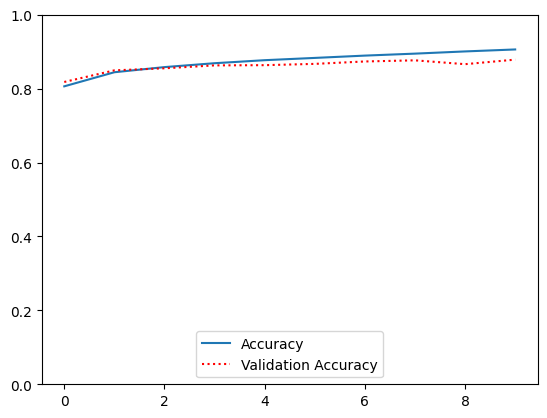

In [44]:
plt.plot(acc,label="Accuracy")
plt.plot(val_acc, linestyle = 'dotted',color = 'r',label="Validation Accuracy")
leg = plt.legend(loc='lower center')
plt.ylim(0,1)
plt.show()

The accuracy and validation accuracy looks good. Now, let's take a look at the loss metric.

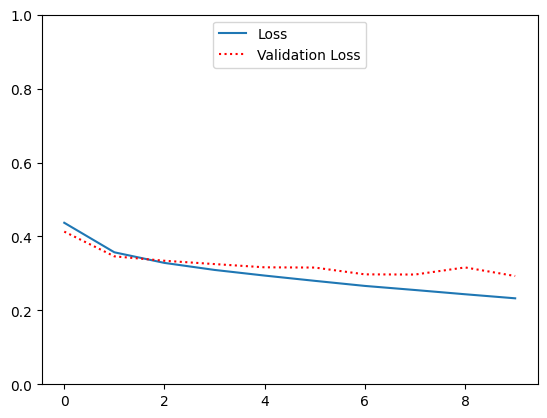

In [46]:
plt.plot(loss,label="Loss")
plt.plot(val_loss, linestyle = 'dotted',color = 'r',label="Validation Loss")
leg = plt.legend(loc='upper center')
plt.ylim(0,1)
plt.show()

The loss curve looks good but the validation curve starts to increase around the 7th epoch. This could be a sign that our model started to overfit towards the end.

Let's test our model on our test images and see how well it predicts the labels.

In [24]:
test_df = pd.read_csv('/content/histopathologic-cancer-detection/sample_submission.csv',usecols = ['id'])
test_df['id'] = test_df['id'].astype(str) + '.tif'
test_df.head()

,id
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [25]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/histopathologic-cancer-detection/test',
    x_col='id',
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


Now that we have processed our test images, let's use our model to predict the labels.

In [26]:
pred = CNN.predict(test_generator, verbose=1)

57458/57458 [==============================] - 198s 3ms/step


In [ ]:
print(pred)

[[3.3781928e-01]
 [8.0352420e-01]
 [3.9691046e-01]
 ...
 [1.3763781e-01]
 [1.9235051e-07]
 [8.7763963e-04]]


To submit our results to Kaggle, we need to combine our predictions with the test image labels, and upload it.

In [ ]:
sub_df = pd.read_csv('/content/histopathologic-cancer-detection/sample_submission.csv')
for i in range(len(pred)):
    if pred[i] > 0.5:
        sub_df['label'][i] = 1
    else:
        sub_df['label'][i] = 0
print(sub_df.head())


After submiting our predictions, we scored 0.8279%!

Let's go back to our model design and see if we can address some of the overfitting, we saw in our loss graph.

# Tuning the Model

The model appeared to overfit slightly to the data. We can address this by adding dropout layers the model.

In [29]:
CNN2 = Sequential()

CNN2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
CNN2.add(BatchNormalization())

CNN2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPool2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.4))

CNN2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPool2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.4))

CNN2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPool2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.2))

CNN2.add(Flatten())
CNN2.add(Dense(units=256, activation='relu'))
CNN2.add(BatchNormalization())

CNN2.add(Dense(units=1, activation='sigmoid'))


opt = Adam(learning_rate=0.0001)
CNN2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

CNN2.build(input_shape=(batch, 64, 64, 3))

CNN2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (256, 62, 62, 16)         448       
                                                                 
 batch_normalization_12 (Ba  (256, 62, 62, 16)         64        
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (256, 60, 60, 16)         2320      
                                                                 
 batch_normalization_13 (Ba  (256, 60, 60, 16)         64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_5 (MaxPoolin  (256, 30, 30, 16)         0         
 g2D)                                                            
                                                      

Now that we have our dropout layers included, let's train our second model and see how it fits.

In [30]:
CNN2_results = CNN2.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
602/602 [==============================] - 411s 671ms/step - loss: 0.4865 - accuracy: 0.7769 - val_loss: 2.4635 - val_accuracy: 0.4079
Epoch 2/10
602/602 [==============================] - 385s 640ms/step - loss: 0.4156 - accuracy: 0.8149 - val_loss: 0.8323 - val_accuracy: 0.6437
Epoch 3/10
602/602 [==============================] - 392s 651ms/step - loss: 0.3927 - accuracy: 0.8274 - val_loss: 0.5292 - val_accuracy: 0.7694
Epoch 4/10
602/602 [==============================] - 386s 641ms/step - loss: 0.3760 - accuracy: 0.8356 - val_loss: 0.4370 - val_accuracy: 0.8155
Epoch 5/10
602/602 [==============================] - 391s 650ms/step - loss: 0.3636 - accuracy: 0.8421 - val_loss: 0.4448 - val_accuracy: 0.8110
Epoch 6/10
602/602 [==============================] - 389s 647ms/step - loss: 0.3534 - accuracy: 0.8470 - val_loss: 0.4189 - val_accuracy: 0.8218
Epoch 7/10
602/602 [==============================] - 386s 642ms/step - loss: 0.3435 - accuracy: 0.8515 - val_loss: 0.4351 -

Now that we have a fitted model, let's take a look at our accuracy and loss. We are hoping to see a steady rise in validation accuracy and a steady decrease in validation loss.

# CNN Model 2 Results

In [31]:
CNN2_results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc2 = CNN2_results.history['accuracy']
val_acc2 = CNN2_results.history['val_accuracy']
loss2 = CNN2_results.history['loss']
val_loss2 = CNN2_results.history['val_loss']

Let's plot our results.

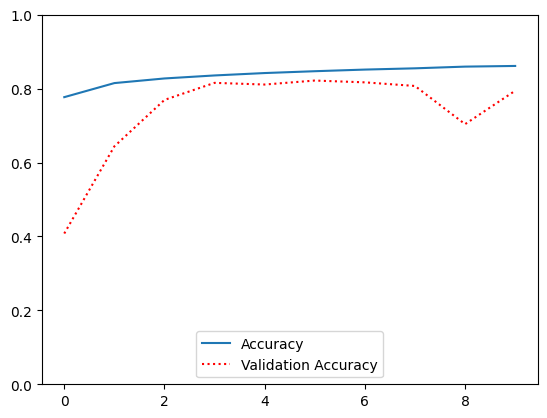

In [47]:
plt.plot(acc2,label="Accuracy")
plt.plot(val_acc2, linestyle = 'dotted',color = 'r',label="Validation Accuracy")
leg = plt.legend(loc='lower center')
plt.ylim(0,1)
plt.show()

We are seeing a similar result as with our first model. The validation accuracy drops around the 7th epoch. Let's take a look at the loss graph.

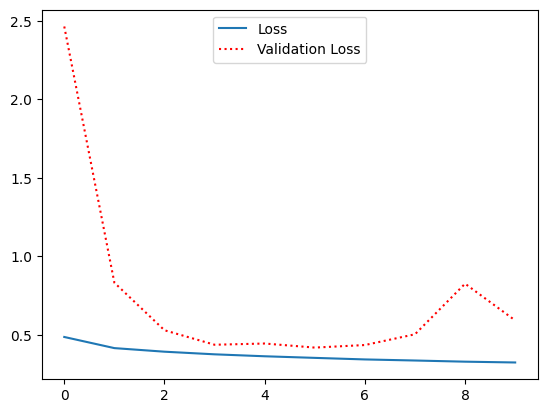

In [34]:
plt.plot(loss2,label="Loss")
plt.plot(val_loss2, linestyle = 'dotted',color = 'r',label="Validation Loss")
leg = plt.legend(loc='upper center')
plt.show()

Again, we see a similar pattern to our first model. It looks as if our model is going to overfit due to the number of epochs.

Let's take a look at how our second model predicts our test data.

In [35]:
pred2 = CNN2.predict(test_generator, verbose=1)

57458/57458 [==============================] - 200s 3ms/step


In [ ]:
sub_df2 = pd.read_csv('/content/histopathologic-cancer-detection/sample_submission.csv')
for i in range(len(pred2)):
    if pred2[i] > 0.5:
        sub_df2['label'][i] = 1
    else:
        sub_df2['label'][i] = 0
print(sub_df2.head())

Our score for the second model was 0.7921%.

Our score went slightly down from the first model. That's not entirely unsurprising. By adding our dropout layers, we were making our model more flexible, so it wouldn't fit as well to the training data. This might indicate our first model wasn't overfitting as much as we first thought. Let’s explore this more in the conclusion.

# Conclusion

First let's take a look at accuracy and validation accuracy. In both models the validation accuracy appeared to drop around the 7 epoch.

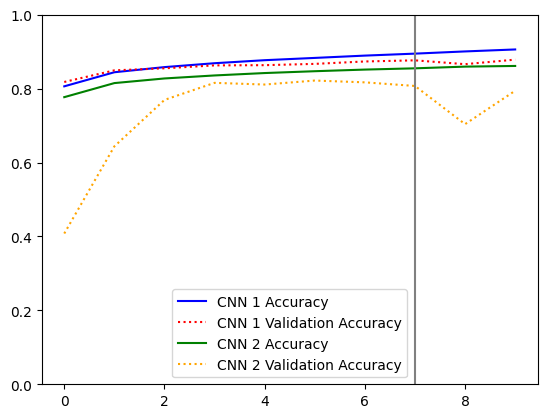

In [55]:
plt.plot(acc,label="CNN 1 Accuracy",color = 'b')
plt.plot(val_acc, linestyle = 'dotted',color = 'r',label="CNN 1 Validation Accuracy")
plt.plot(acc2,label="CNN 2 Accuracy",color = 'g')
plt.plot(val_acc2, linestyle = 'dotted',color = 'orange',label="CNN 2 Validation Accuracy")
plt.axvline(7,color = 'grey')
leg = plt.legend(loc='lower center')
plt.ylim(0,1)
plt.show()

In the loss and validation loss graph of both models, we can a similar trend of increased validation loss around the 6th and 7th epoch.

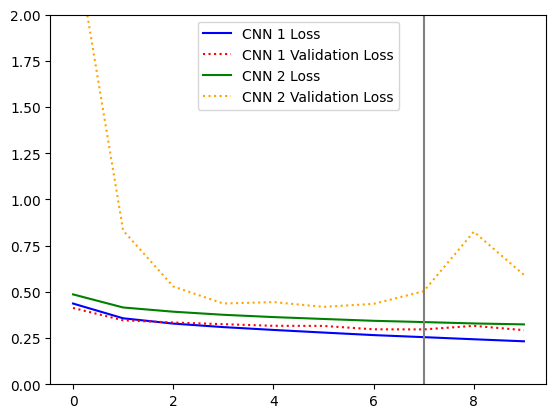

In [57]:
plt.plot(loss,label="CNN 1 Loss",color = 'b')
plt.plot(val_loss, linestyle = 'dotted',color = 'r',label="CNN 1 Validation Loss")
plt.plot(loss2,label="CNN 2 Loss",color = 'g')
plt.plot(val_loss2, linestyle = 'dotted',color = 'orange',label="CNN 2 Validation Loss")
plt.axvline(7,color = 'grey')
plt.ylim(0,2)
leg = plt.legend(loc='upper center')
plt.show()

Our model's scored around 80%. To improve on that score, we may want to train the model to 7 epochs or adjust the batch size number. We can also investigate increasing our data augmentation. A third method may be adding another convolution layer, but this will increase the run time of the model so tuning the parameters further may be a more economical approach.

Overall, our goal was to build a CNN model that can identify cancer in images of cells. We were able to predict 80% of the test images accurately.

# Refrences

*   https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
*   https://www.kaggle.com/code/mrinaljaiswal/cancer-cnn-project
*   https://www.baeldung.com/cs/batch-normalization-cnn
*   https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
*   https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
*   https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [37]:
#from google.colab import files

In [38]:
#sub_df.to_csv('CNN Sub.csv',encoding = 'utf-8-sig')
#files.download('CNN Sub.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
#sub_df2.to_csv('CNN Sub2.csv',encoding = 'utf-8-sig')
#files.download('CNN Sub2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#df_sample_sub.to_csv('output.csv', encoding = 'utf-8-sig')
#files.download('output.csv')